In [ ]:
import pandas as pd
import numpy as np
import re

### 1. Data Preprocessing

In [ ]:
from google.colab import drive
import os
import pandas as pd

drive.mount('/content/drive')

# Read Content
base_path = '/content/drive/My Drive/NUS MSBA/Semester 2/BT5153_AppliedMachineLearningforBusinessAnalytics/Group Project'
#read dataset and drop bad lines
comments_us= pd.read_csv(os.path.join(base_path, 'UScomments.csv'), on_bad_lines='skip')
videos_us = pd.read_csv(os.path.join(base_path, 'USvideos.csv'), on_bad_lines='skip')
comments_GB = pd.read_csv(os.path.join(base_path, 'GBcomments.csv'), on_bad_lines='skip')
videos_GB = pd.read_csv(os.path.join(base_path, 'GBvideos.csv'), on_bad_lines='skip')

Mounted at /content/drive


<ipython-input-2-c263d5acd3ae>:10: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_us= pd.read_csv(os.path.join(base_path, 'UScomments.csv'), on_bad_lines='skip')


#### 1.1 Check Null Values

In [ ]:
comments_us.isnull().sum()

video_id         0
comment_text    26
likes            0
replies          0
dtype: int64

In [ ]:
#drop null comment text rows
comments_us.dropna(inplace = True)

In [ ]:
videos_us.isnull().sum()

video_id          0
title             0
channel_title     0
category_id       0
tags              0
views             0
likes             0
dislikes          0
comment_total     0
thumbnail_link    0
date              0
dtype: int64

In [ ]:
comments_GB.isnull().sum()

video_id         0
comment_text    28
likes            0
replies          0
dtype: int64

In [ ]:
comments_GB.dropna(inplace = True)

In [ ]:
videos_GB.isnull().sum()

video_id          0
title             0
channel_title     0
category_id       0
tags              0
views             0
likes             0
dislikes          0
comment_total     0
thumbnail_link    0
date              0
dtype: int64

#### 1.2 Convert Date into Datetime and Drop Thumbnail_link Column

In [ ]:
videos_us['date'] = pd.to_datetime(videos_us['date'].astype(str) + '.2018', format='%d.%m.%Y', errors='coerce')
videos_GB['date'] = pd.to_datetime(videos_GB['date'].astype(str) + '.2018', format='%d.%m.%Y', errors='coerce')

In [ ]:
videos_us.drop(columns=['thumbnail_link'], inplace=True)
videos_GB.drop(columns=['thumbnail_link'], inplace=True)

#### 1.3 Convert Tiitle and Tag Format

In [ ]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower().strip()
    text = re.sub(r'[^\w\s]', '', text)
    return text

videos_us['title'] = videos_us['title'].astype(str).apply(clean_text)
videos_us['channel_title'] = videos_us['channel_title'].astype(str).apply(clean_text)
videos_GB['title'] = videos_GB['title'].astype(str).apply(clean_text)
videos_GB['channel_title'] = videos_GB['channel_title'].astype(str).apply(clean_text)


In [ ]:
def process_tags(tag_string):
    if pd.isnull(tag_string) or tag_string.strip() == '[none]':
        return []
    return [t.strip().lower() for t in tag_string.split('|')]

videos_us['tags_list'] = videos_us['tags'].apply(process_tags)
videos_us['tag_count'] = videos_us['tags_list'].apply(len)
videos_GB['tags_list'] = videos_GB['tags'].apply(process_tags)
videos_GB['tag_count'] = videos_GB['tags_list'].apply(len)


#### 1.4 Merge Dataset

In [ ]:
merged_us = comments_us.merge(videos_us, on='video_id', how='left')
merged_GB = comments_GB.merge(videos_GB, on='video_id', how='left')

In [ ]:
merged_us.rename(columns={
    'likes_x': 'comment_likes',
    'likes_y': 'video_likes',
    'replies': 'comment_replies',
    'comment_total': 'video_comment_total'
}, inplace=True)

merged_GB.rename(columns={
    'likes_x': 'comment_likes',
    'likes_y': 'video_likes',
    'replies': 'comment_replies',
    'comment_total': 'video_comment_total'
}, inplace=True)

In [ ]:
# Convert likes and replies to integers
merged_us['comment_likes'] = pd.to_numeric(merged_us['comment_likes'], errors='coerce').fillna(0).astype(int) #likes on comment
merged_us['video_likes'] = pd.to_numeric(merged_us['video_likes'], errors='coerce').fillna(0).astype(int) #lieks on video
merged_us['comment_replies'] = pd.to_numeric(merged_us['comment_replies'], errors='coerce').fillna(0).astype(int)
merged_GB['comment_likes'] = pd.to_numeric(merged_GB['comment_likes'], errors='coerce').fillna(0).astype(int)
merged_GB['video_likes'] = pd.to_numeric(merged_GB['video_likes'], errors='coerce').fillna(0).astype(int)
merged_GB['comment_replies'] = pd.to_numeric(merged_GB['comment_replies'], errors='coerce').fillna(0).astype(int)

#### 1.5 Feature Engineering

In [ ]:
merged_us['comment_length'] = merged_us['comment_text'].astype(str).apply(len)
merged_GB['comment_length'] = merged_GB['comment_text'].astype(str).apply(len)

In [ ]:
merged_us['comment_likes'] = merged_us['comment_likes'] + merged_us['comment_replies']
merged_GB['comment_likes'] = merged_GB['comment_likes'] + merged_GB['comment_replies']

In [ ]:
merged_us['like_rate_video'] = merged_us.apply(
    lambda row: row['video_likes'] / row['views'] if row['views'] > 0 else 0,
    axis=1
) #likes per view for each video
merged_us['comment_rate'] = merged_us['video_comment_total'] / merged_us['views']
merged_GB['like_rate_video'] = merged_GB.apply(
    lambda row: row['video_likes'] / row['views'] if row['views'] > 0 else 0,
    axis=1
)
merged_GB['comment_rate'] = merged_GB['video_comment_total'] / merged_GB['views']

In [ ]:
# Like to Dislike Ratio
merged_us['like_dislike_ratio'] = np.where(
    merged_us['dislikes'] > 0,
    merged_us['video_likes'] / merged_us['dislikes'],
    np.nan
)
merged_GB['like_dislike_ratio'] = np.where(
    merged_GB['dislikes'] > 0,
    merged_GB['video_likes'] / merged_GB['dislikes'],
    np.nan
)
# Views per Like (lower = more engaging)
merged_us['views_per_like'] = np.where(
    merged_us['video_likes'] > 0,
    merged_us['views'] / merged_us['video_likes'],
    np.nan
)
merged_GB['views_per_like'] = np.where(
    merged_GB['video_likes'] > 0,
    merged_GB['views'] / merged_GB['video_likes'],
    np.nan
)

### 2. EDA

#### 2.1 US dataset (Optional)

In [ ]:
# Basic structure
merged_us.info()

# Summary stats
merged_us.describe(include='all')

# Missing values
merged_us.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940803 entries, 0 to 2940802
Data columns (total 20 columns):
 #   Column               Dtype         
---  ------               -----         
 0   video_id             object        
 1   comment_text         object        
 2   comment_likes        int64         
 3   comment_replies      int64         
 4   title                object        
 5   channel_title        object        
 6   category_id          int64         
 7   tags                 object        
 8   views                int64         
 9   video_likes          int64         
 10  dislikes             int64         
 11  video_comment_total  int64         
 12  date                 datetime64[ns]
 13  tags_list            object        
 14  tag_count            int64         
 15  comment_length       int64         
 16  like_rate_video      float64       
 17  comment_rate         float64       
 18  like_dislike_ratio   float64       
 19  views_per_like       

,0
video_id,0
comment_text,0
comment_likes,0
comment_replies,0
title,0
channel_title,0
category_id,0
tags,0
views,0
video_likes,0


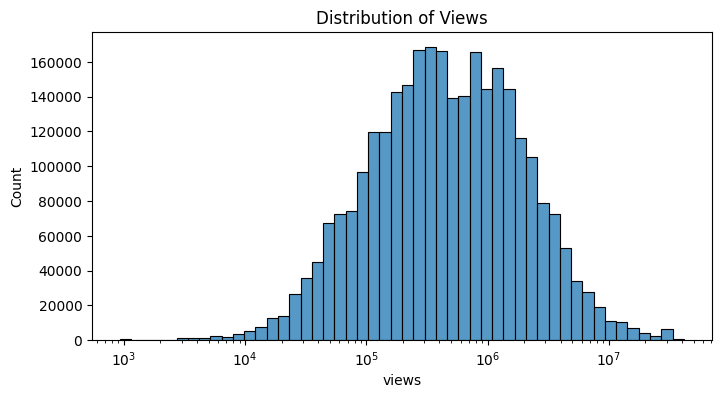

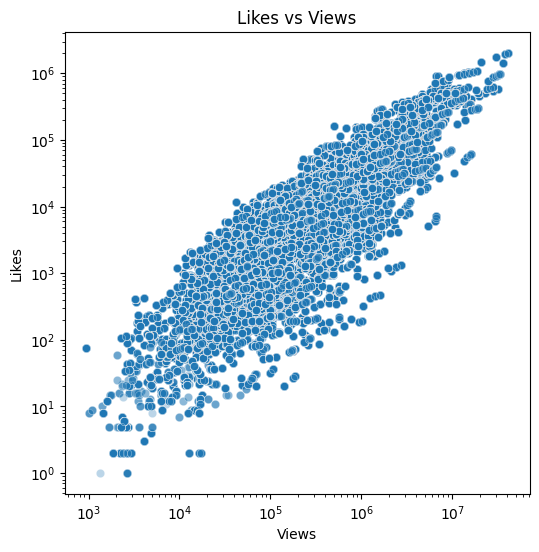

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Views distribution
plt.figure(figsize=(8,4))
sns.histplot(merged_us['views'], bins=50, log_scale=(True, False))
plt.title('Distribution of Views')
plt.show()

# Likes vs Views (log scale)
plt.figure(figsize=(6,6))
sns.scatterplot(x='views', y='video_likes', data=merged_us, alpha=0.3)
plt.xscale('log'); plt.yscale('log')
plt.title('Likes vs Views')
plt.xlabel('Views'); plt.ylabel('Likes')
plt.show()


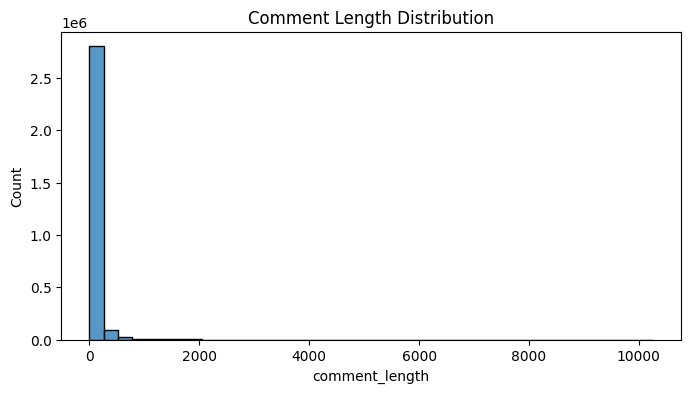

,comment_text,comment_likes
701410,What if Mable was the duck??,49273
701411,What if Mable was the duck??,49273
701409,What if Mable was the duck??,49273
701408,What if Mable was the duck??,49273
631788,What if Mable was the duck??,48286
631786,What if Mable was the duck??,48286
631787,What if Mable was the duck??,48286
631785,What if Mable was the duck??,48286
536521,What if Mable was the duck??,45816
536524,What if Mable was the duck??,45816


In [ ]:
# Comment length distribution
plt.figure(figsize=(8,4))
sns.histplot(merged_us['comment_length'], bins=40)
plt.title('Comment Length Distribution')
plt.show()

# Comments with most likes
merged_us[['comment_text', 'comment_likes']].sort_values(by='comment_likes', ascending=False).head(10)


In [ ]:
# Top videos by views
top_videos = merged_us.groupby('title').agg({
    'views': 'max',
    'video_likes': 'max',
    'video_comment_total': 'max'
}).sort_values(by='views', ascending=False).head(10)

top_videos


,views,video_likes,video_comment_total
title,,,
bts 방탄소년단 dna official mv,41500672,2010366,736179
zayn dusk till dawn ft sia,36323498,1431683,100661
eminem rips donald trump in bet hip hop awards freestyle cypher,33191594,982842,337603
shakira perro fiel official video ft nicky jam,32136948,578266,40071
star wars the last jedi trailer official,27909589,631087,101673
justice league official heroes trailer,19194567,298938,56329
logan paul outta my hair official music video,18809766,1075133,164275
sneaky toddler steals prince harrys popcorn,15952413,61765,6799
primitive technology mud bricks,15579127,348653,36857


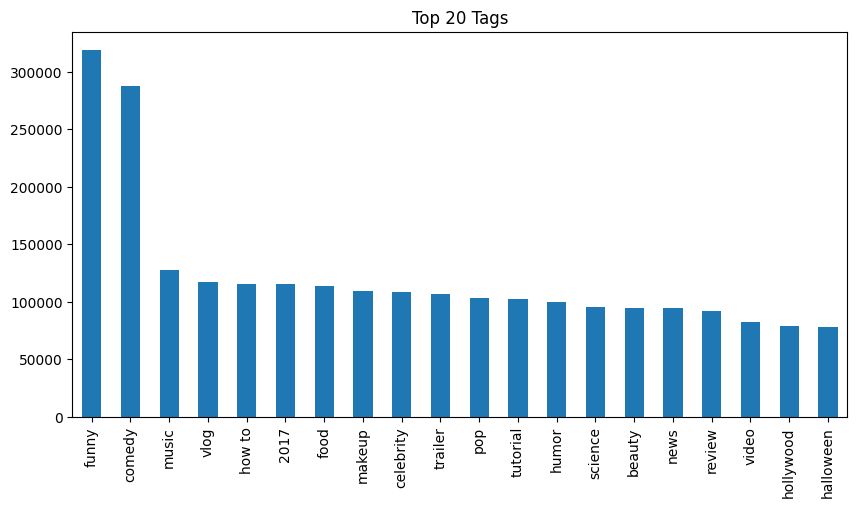

In [ ]:
# Most used tags
from collections import Counter
from itertools import chain

all_tags = list(chain.from_iterable(merged_us['tags_list']))
tag_counts = pd.Series(Counter(all_tags)).sort_values(ascending=False)
tag_counts.head(20).plot(kind='bar', figsize=(10,5), title='Top 20 Tags')
plt.show()


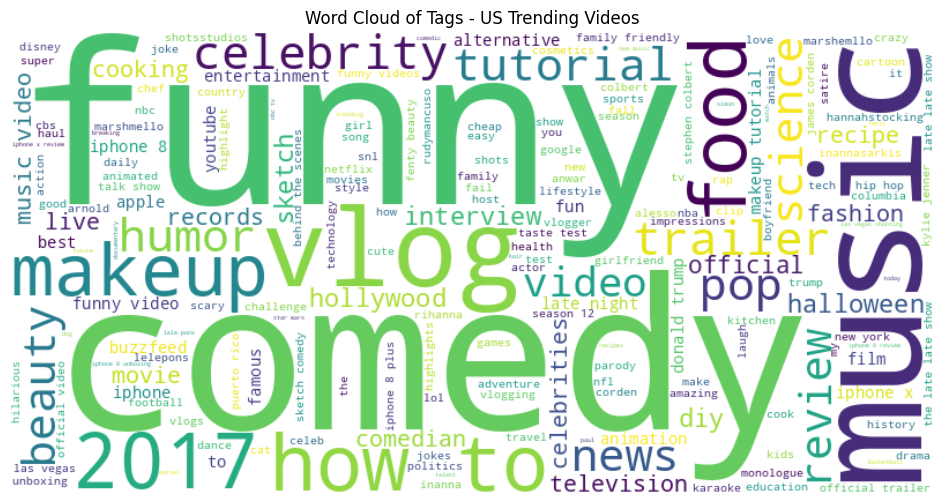

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the frequency dictionary from your tag counts
tag_freq_dict = dict(tag_counts)

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'  # You can change this
).generate_from_frequencies(tag_freq_dict)

# Plot word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tags - US Trending Videos')
plt.show()


#### 2.2 GB Dataset

In [ ]:
# Basic structure
merged_GB.info()

# Summary stats
merged_GB.describe(include='all')

# Missing values
merged_GB.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4208923 entries, 0 to 4208922
Data columns (total 20 columns):
 #   Column               Dtype         
---  ------               -----         
 0   video_id             object        
 1   comment_text         object        
 2   comment_likes        int64         
 3   comment_replies      int64         
 4   title                object        
 5   channel_title        object        
 6   category_id          int64         
 7   tags                 object        
 8   views                int64         
 9   video_likes          int64         
 10  dislikes             int64         
 11  video_comment_total  int64         
 12  date                 datetime64[ns]
 13  tags_list            object        
 14  tag_count            int64         
 15  comment_length       int64         
 16  like_rate_video      float64       
 17  comment_rate         float64       
 18  like_dislike_ratio   float64       
 19  views_per_like       

,0
video_id,0
comment_text,0
comment_likes,0
comment_replies,0
title,0
channel_title,0
category_id,0
tags,0
views,0
video_likes,0


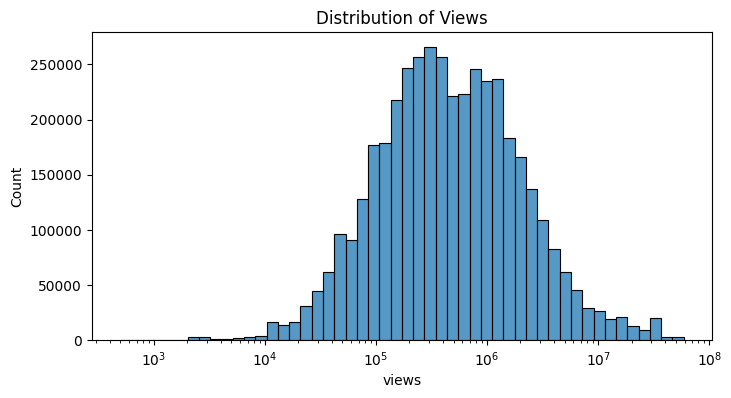

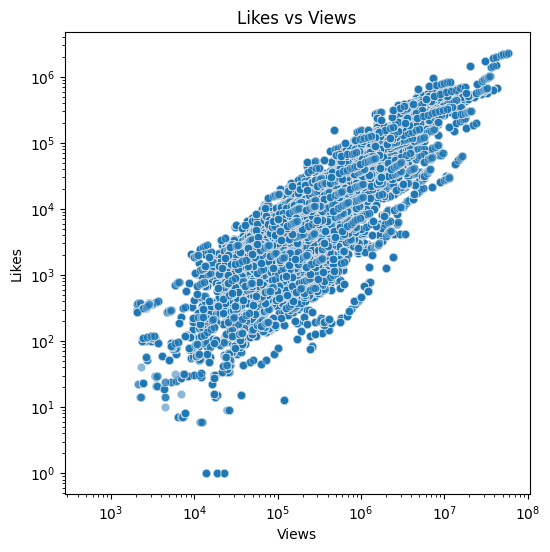

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Views distribution
plt.figure(figsize=(8,4))
sns.histplot(merged_GB['views'], bins=50, log_scale=(True, False))
plt.title('Distribution of Views')
plt.show()

# Likes vs Views (log scale)
plt.figure(figsize=(6,6))
sns.scatterplot(x='views', y='video_likes', data=merged_GB, alpha=0.3)
plt.xscale('log'); plt.yscale('log')
plt.title('Likes vs Views')
plt.xlabel('Views'); plt.ylabel('Likes')
plt.show()


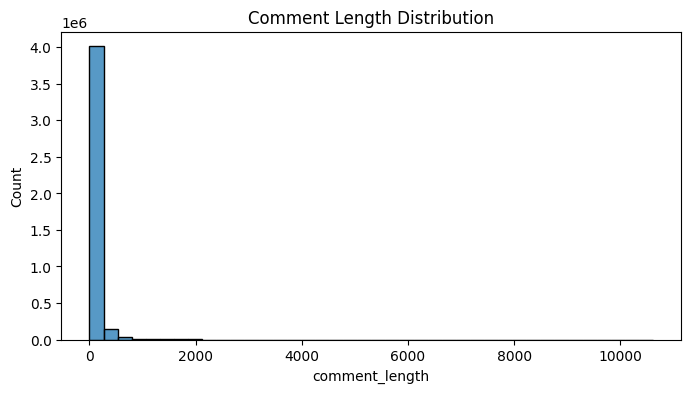

,comment_text,comment_likes
54498,WE'RE CRUSHING THE CHARTS!!!!! THANK YOU ALL F...,61151
4145415,🚨🚨WARNING!! STOP HERE IF U DONT WANT SPOILERS!...,28353
4145417,🚨🚨WARNING!! STOP HERE IF U DONT WANT SPOILERS!...,28353
4145416,🚨🚨WARNING!! STOP HERE IF U DONT WANT SPOILERS!...,28353
4050699,🚨🚨WARNING!! STOP HERE IF U DONT WANT SPOILERS!...,26922
4050701,🚨🚨WARNING!! STOP HERE IF U DONT WANT SPOILERS!...,26922
4050700,🚨🚨WARNING!! STOP HERE IF U DONT WANT SPOILERS!...,26922
1168965,HI DIY QUEENS 👑❤️ it's finally HERREEEE!! down...,24501
1168964,HI DIY QUEENS 👑❤️ it's finally HERREEEE!! down...,24501
1168963,HI DIY QUEENS 👑❤️ it's finally HERREEEE!! down...,24501


In [ ]:
# Comment length distribution
plt.figure(figsize=(8,4))
sns.histplot(merged_GB['comment_length'], bins=40)
plt.title('Comment Length Distribution')
plt.show()

# Comments with most likes
merged_GB[['comment_text', 'comment_likes']].sort_values(by='comment_likes', ascending=False).head(10)


In [ ]:
# Top videos by views
top_videos = merged_GB.groupby('title').agg({
    'views': 'max',
    'video_likes': 'max',
    'video_comment_total': 'max'
}).sort_values(by='views', ascending=False).head(10)

top_videos


,views,video_likes,video_comment_total
title,,,
bts 방탄소년단 dna official mv,58961407,2289911,813322
yandel como antes official video ft wisin,42486342,678389,48429
zayn dusk till dawn ft sia,41959549,1502097,104931
shakira perro fiel official video ft nicky jam,38144440,624008,41131
eminem rips donald trump in bet hip hop awards freestyle cypher,35300501,1022015,340869
star wars the last jedi trailer official,32714551,674617,113399
sam smith too good at goodbyes official video,29080061,615290,26738
de la ghetto daddy yankee ozuna chris jeday la formula video oficial,23699605,199904,7961
justice league official heroes trailer,20959406,308120,61809


/var/folders/44/32dbp09x3l701sp0zkk7sgrr0000gn/T/ipykernel_68322/4210163521.py:20: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  plt.tight_layout()
/var/folders/44/32dbp09x3l701sp0zkk7sgrr0000gn/T/ipykernel_68322/4210163521.py:20: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  plt.tight_layout()
/var/folders/44/32dbp09x3l701sp0zkk7sgrr0000gn/T/ipykernel_68322/4210163521.py:20: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
/var/folders/44/32dbp09x3l701sp0zkk7sgrr0000gn/T/ipykernel_68322/4210163521.py:20: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  plt.tight_layout()
/var/folders/44/32dbp09x3l701sp0zkk7sgrr0000gn/T/ipykernel_68322/4210163521.py:20: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  plt.tight_layout()


<Figure size 1000x700 with 0 Axes>

/Users/stellali/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/stellali/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/stellali/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/stellali/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/stellali/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  fig.canvas.print_f

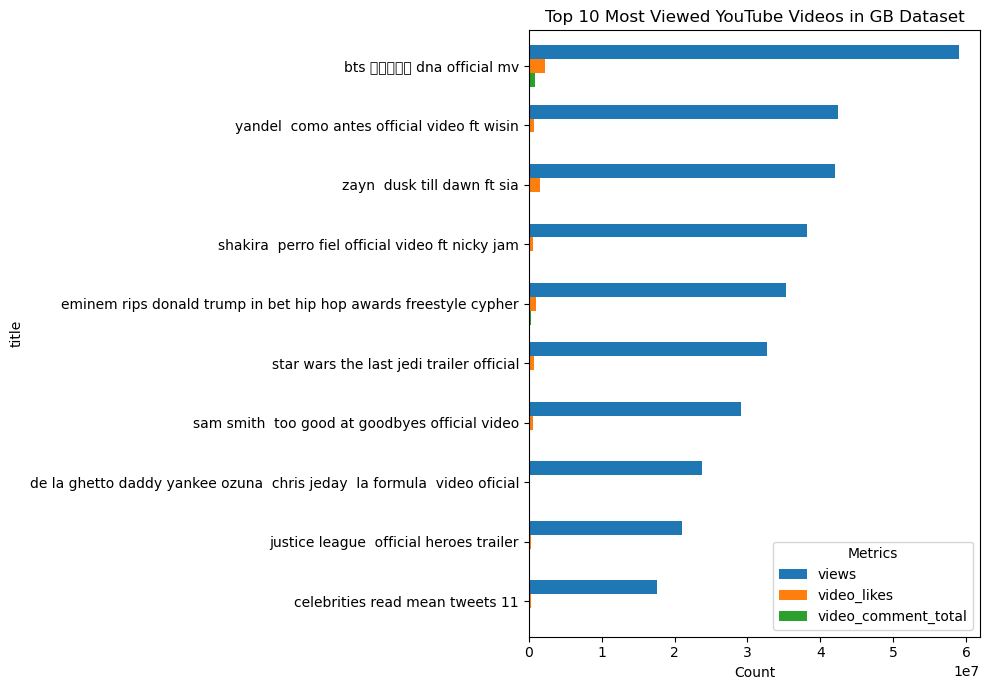

In [ ]:

import matplotlib.pyplot as plt

top_videos = top_videos.reset_index()
# Set title as the index for better plotting
top_videos_plot = top_videos.set_index('title')

# Plot
plt.figure(figsize=(10, 7))
top_videos_plot[['views', 'video_likes', 'video_comment_total']].plot(
    kind='barh',
    stacked=False,
    figsize=(10, 7),
    width=0.7
)

plt.xlabel('Count')
plt.title('Top 10 Most Viewed YouTube Videos in GB Dataset')
plt.gca().invert_yaxis()  # Highest views on top
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


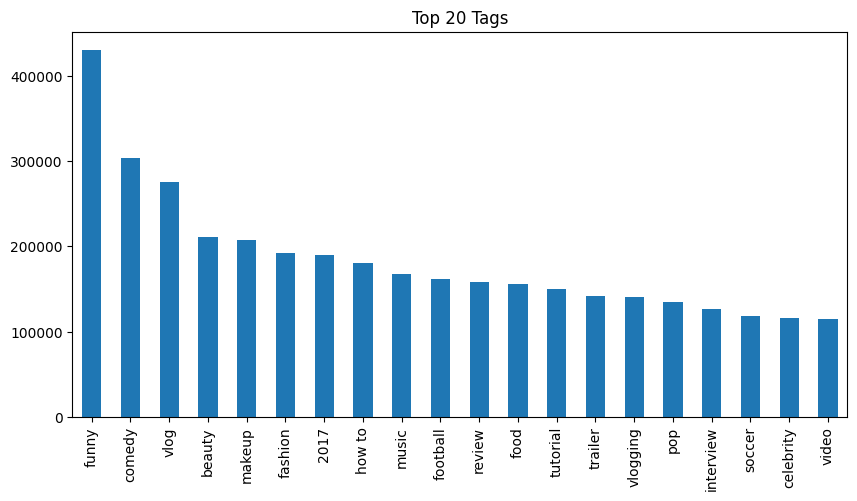

In [ ]:
# Most used tags
from collections import Counter
from itertools import chain

all_tags = list(chain.from_iterable(merged_GB['tags_list']))
tag_counts = pd.Series(Counter(all_tags)).sort_values(ascending=False)
tag_counts.head(20).plot(kind='bar', figsize=(10,5), title='Top 20 Tags')
plt.show()

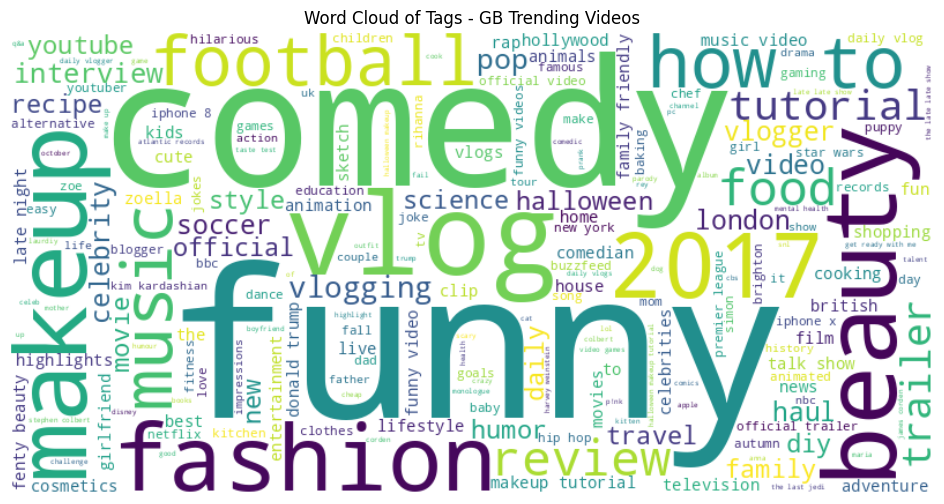

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the frequency dictionary from your tag counts
tag_freq_dict = dict(tag_counts)

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'  # You can change this
).generate_from_frequencies(tag_freq_dict)

# Plot word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tags - GB Trending Videos')
plt.show()


### 3. Sentiment Analysis - Vader

#### 3.1 US Analysis(Optional)

In [ ]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()


def get_sentiment_label(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

merged_us['sentiment'] = merged_us['comment_text'].apply(get_sentiment_label)

sentiment_counts = merged_us['sentiment'].value_counts()
print(sentiment_counts)

video_sentiment = merged_us.groupby('video_id')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
video_sentiment.head()

channel_sentiment = merged_us.groupby('channel_title')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
channel_sentiment.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00
sentiment
positive    1434724
neutral      896085
negative     609994
Name: count, dtype: int64


sentiment,negative,neutral,positive
channel_title,,,
100isnow,0.000000,0.000000,1.000000
112vevo,0.092784,0.185567,0.721649
1791l,0.325000,0.262500,0.412500
20th century fox,0.253877,0.387268,0.358855
2cellos,0.072500,0.292500,0.635000


In [ ]:
video_sentiment.head()

sentiment,negative,neutral,positive
video_id,,,
--JinobXWPk,0.270000,0.410000,0.320000
-1fzGnFwz9M,0.220000,0.200000,0.580000
-3AGlBYyLjo,0.500000,0.500000,0.000000
-5sCWsLlTCI,0.164179,0.283582,0.552239
-6Zc8Co2H3w,0.117500,0.347500,0.535000


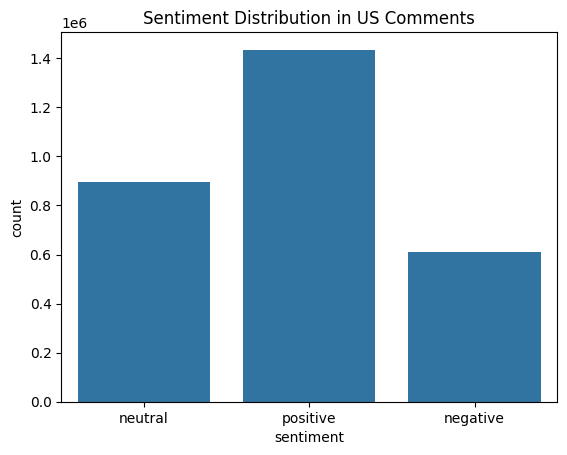

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=merged_us, x='sentiment')
plt.title('Sentiment Distribution in US Comments')
plt.show()

In [ ]:
merged_us['category_id'].value_counts()


,count
category_id,
24,594089
10,520930
23,323480
22,321094
26,313568
28,192244
25,184232
1,146196
27,122929


In [ ]:
category_map = {
    1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music',
    15: 'Pets & Animals', 17: 'Sports', 19: 'Travel & Events', 20: 'Gaming',
    22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment',
    25: 'News & Politics', 26: 'Howto & Style', 27: 'Education',
    28: 'Science & Technology', 29: 'Nonprofits & Activism', 43: 'Shows'
}

merged_us['category_name'] = merged_us['category_id'].map(category_map)


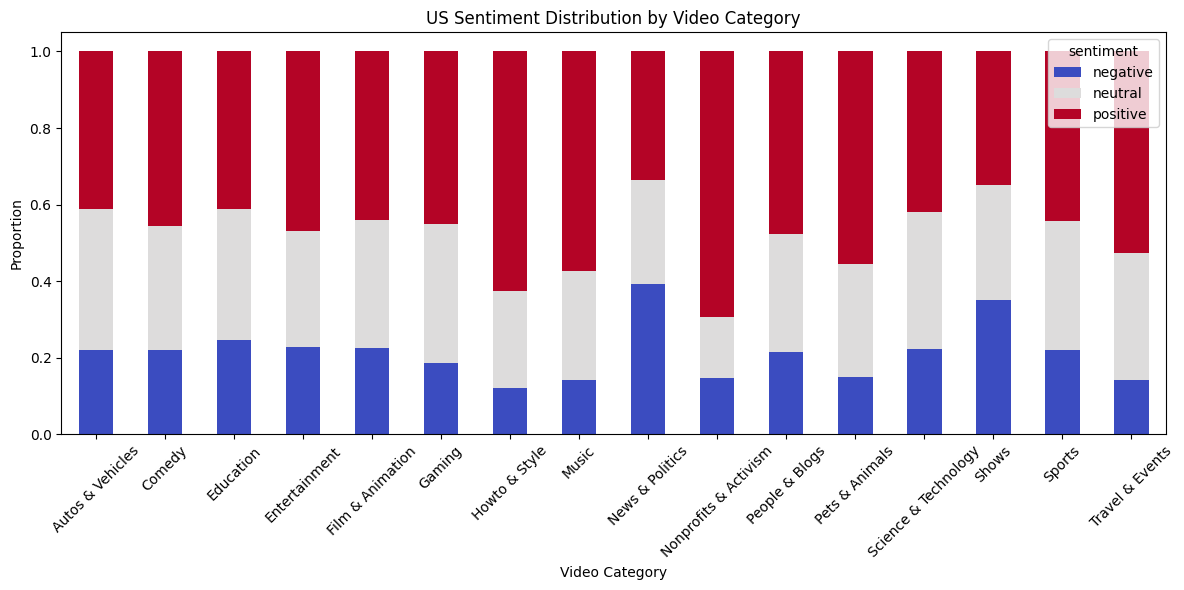

In [ ]:
category_sentiment = merged_us.groupby('category_name')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
category_sentiment.head()

category_sentiment.plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
plt.title('US Sentiment Distribution by Video Category')
plt.ylabel('Proportion')
plt.xlabel('Video Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
category_sentiment = (
    merged_us
    .groupby('category_name')['sentiment']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .round(3)
)

print(category_sentiment)

sentiment              negative  neutral  positive
category_name                                     
Autos & Vehicles          0.220    0.367     0.413
Comedy                    0.220    0.323     0.457
Education                 0.246    0.341     0.413
Entertainment             0.228    0.304     0.468
Film & Animation          0.225    0.335     0.440
Gaming                    0.187    0.363     0.450
Howto & Style             0.122    0.253     0.625
Music                     0.142    0.285     0.574
News & Politics           0.391    0.273     0.336
Nonprofits & Activism     0.146    0.161     0.693
People & Blogs            0.215    0.309     0.476
Pets & Animals            0.150    0.294     0.556
Science & Technology      0.223    0.356     0.421
Shows                     0.350    0.300     0.350
Sports                    0.219    0.339     0.442
Travel & Events           0.142    0.332     0.527


#### 3.2 GB Analysis

In [ ]:
def get_sentiment_label(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'


merged_GB['sentiment'] = merged_GB['comment_text'].apply(get_sentiment_label)

sentiment_counts = merged_GB['sentiment'].value_counts()
print(sentiment_counts)

video_sentiment = merged_GB.groupby('video_id')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
video_sentiment.head()

channel_sentiment = merged_GB.groupby('channel_title')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
channel_sentiment.head()


sentiment
positive    2164894
neutral     1241943
negative     802254
Name: count, dtype: int64


sentiment,negative,neutral,positive
channel_title,,,
100PercentChelsea,0.352500,0.242500,0.405000
1theK (원더케이),0.050600,0.481200,0.468200
2017 FlashTrendinG,0.534286,0.250000,0.215714
20th Century Fox,0.265781,0.367146,0.367073
21 Savage,0.460000,0.276667,0.263333


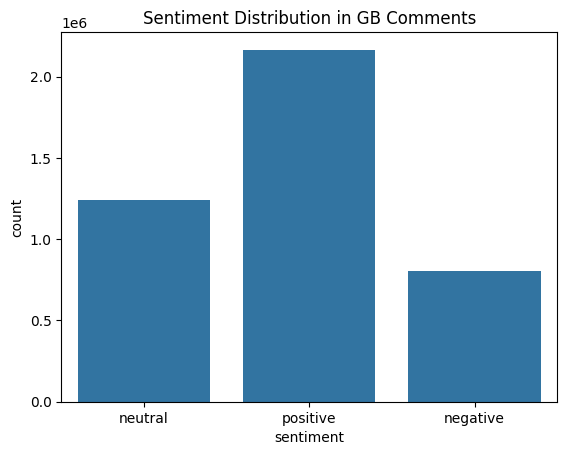

In [ ]:
sns.countplot(data=merged_GB, x='sentiment')
plt.title('Sentiment Distribution in GB Comments')
plt.show()

In [ ]:
merged_GB['category_id'].value_counts()


,count
category_id,
24,827097
10,721030
26,616147
22,595940
23,311794
17,294554
1,215339
28,153853
25,138925


In [ ]:
category_map = {
    1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music',
    15: 'Pets & Animals', 17: 'Sports', 19: 'Travel & Events', 20: 'Gaming',
    22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment',
    25: 'News & Politics', 26: 'Howto & Style', 27: 'Education',
    28: 'Science & Technology', 29: 'Nonprofits & Activism'
}

merged_GB['category_name'] = merged_GB['category_id'].map(category_map)


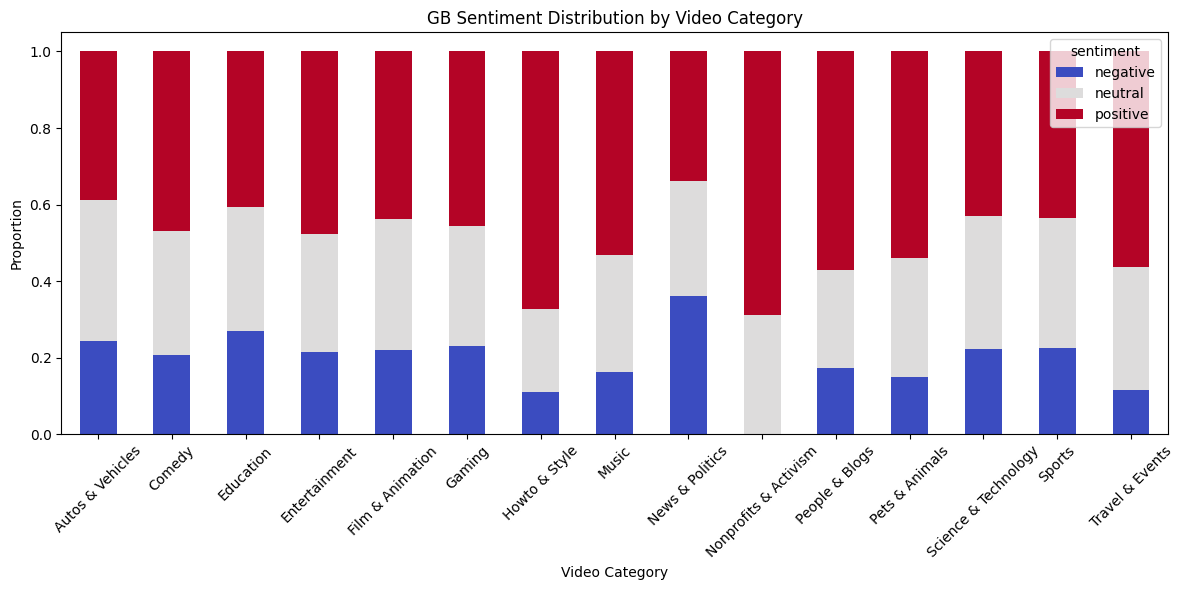

In [ ]:
category_sentiment = merged_GB.groupby('category_name')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
category_sentiment.head()

category_sentiment.plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
plt.title('GB Sentiment Distribution by Video Category')
plt.ylabel('Proportion')
plt.xlabel('Video Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
category_sentiment = (
    merged_GB
    .groupby('category_name')['sentiment']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .round(3)
)

print(category_sentiment)

sentiment              negative  neutral  positive
category_name                                     
Autos & Vehicles          0.244    0.368     0.388
Comedy                    0.206    0.325     0.469
Education                 0.269    0.325     0.406
Entertainment             0.214    0.309     0.477
Film & Animation          0.221    0.342     0.437
Gaming                    0.230    0.314     0.457
Howto & Style             0.109    0.217     0.674
Music                     0.161    0.307     0.532
News & Politics           0.361    0.300     0.339
Nonprofits & Activism     0.000    0.312     0.688
People & Blogs            0.174    0.256     0.570
Pets & Animals            0.149    0.310     0.540
Science & Technology      0.223    0.347     0.431
Sports                    0.224    0.341     0.435
Travel & Events           0.114    0.323     0.562


### 4. Sentiment Analysis - Bert - GB Only

In [ ]:
!pip install transformers
!pip install torch
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import pandas as pd
import torch
from datasets import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, return_all_scores=False)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
comment_ds = Dataset.from_pandas(merged_GB[['comment_text']].dropna().rename(columns={'comment_text': 'text'}))

In [ ]:
texts = comment_ds['text']
labels = []
batch_size=64


from transformers import TextClassificationPipeline
sentiment_pipeline = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=False,
    truncation=True,
    max_length=512,
    batch_size=64,
    top_k=1
)

for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i:i+batch_size]
    try:
        results = sentiment_pipeline(batch_texts, truncation=True)
        labels += [r[0]['label'] for r in results]
    except Exception as e:
        print(f"Batch {i} failed:", e)
        labels += ['LABEL_1'] * len(batch_texts)  # fallback 为 neutral

merged_GB = merged_GB.loc[:len(labels)-1].copy()
merged_GB['bert_sentiment'] = labels

Device set to use cuda:0
100%|██████████| 65765/65765 [1:24:55<00:00, 12.91it/s]


In [ ]:
label_map = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}
merged_GB['bert_sentiment'] = merged_GB['bert_sentiment'].map(label_map)

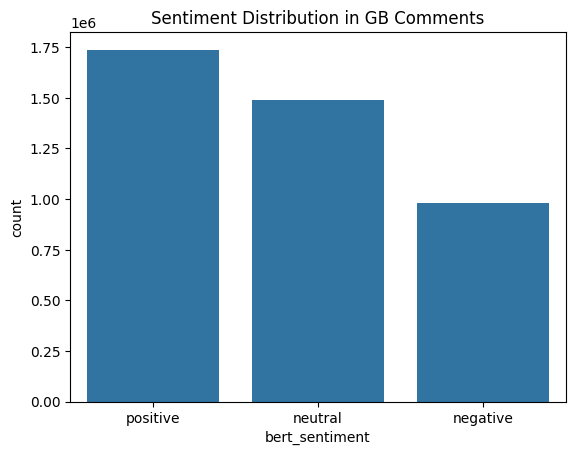

In [ ]:
sns.countplot(data=merged_GB, x='bert_sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution in GB Comments')
plt.show()

In [ ]:
category_map = {
    1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music',
    15: 'Pets & Animals', 17: 'Sports', 19: 'Travel & Events', 20: 'Gaming',
    22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment',
    25: 'News & Politics', 26: 'Howto & Style', 27: 'Education',
    28: 'Science & Technology', 29: 'Nonprofits & Activism'
}

merged_GB['category_name'] = merged_GB['category_id'].map(category_map)

category_sentiment = (
    merged_GB.groupby('category_name')['bert_sentiment']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .reindex(columns=['positive', 'neutral', 'negative'])  # 确保顺序一致
)

print (category_sentiment)

bert_sentiment         positive   neutral  negative
category_name                                      
Autos & Vehicles       0.248126  0.475326  0.276548
Comedy                 0.338714  0.384305  0.276981
Education              0.230650  0.402443  0.366907
Entertainment          0.357099  0.370045  0.272856
Film & Animation       0.311351  0.432332  0.256318
Gaming                 0.313313  0.409705  0.276982
Howto & Style          0.607589  0.263948  0.128463
Music                  0.512861  0.333474  0.153666
News & Politics        0.155638  0.334821  0.509541
Nonprofits & Activism  0.660714  0.232143  0.107143
People & Blogs         0.466583  0.310740  0.222677
Pets & Animals         0.429324  0.357861  0.212814
Science & Technology   0.269043  0.454668  0.276290
Sports                 0.281603  0.449722  0.268674
Travel & Events        0.476174  0.341820  0.182006


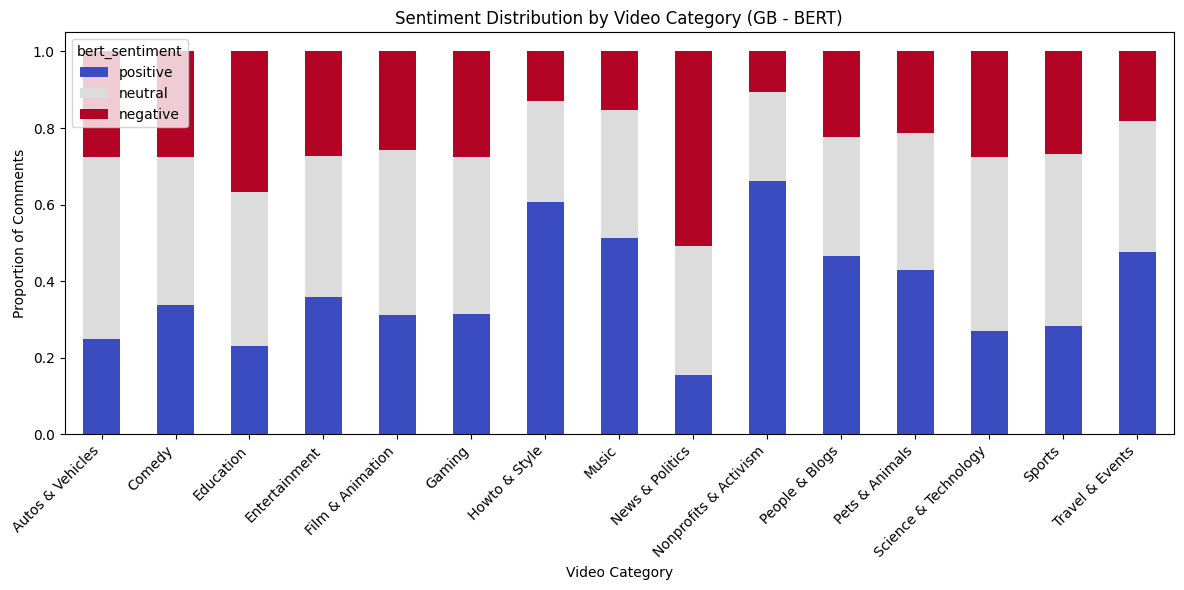

In [ ]:
category_sentiment.plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
plt.title('Sentiment Distribution by Video Category (GB - BERT)')
plt.ylabel('Proportion of Comments')
plt.xlabel('Video Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 5. Influence Score

In [ ]:
def compute_influence_score(df):

    influencer_df = df.groupby('channel_title').agg({
        'video_id': 'count',
        'views': 'sum',
        'likes': 'sum',
        'comment_total': 'sum'
    }).rename(columns={'video_id': 'num_videos'}).reset_index()

    influencer_df['avg_views'] = influencer_df['views'] / influencer_df['num_videos']
    influencer_df['avg_likes'] = influencer_df['likes'] / influencer_df['num_videos']
    influencer_df['avg_comments'] = influencer_df['comment_total'] / influencer_df['num_videos']
    influencer_df['engagement_rate'] = (
        (influencer_df['likes'] + influencer_df['comment_total']) / influencer_df['views']
    )


    for col in ['avg_views', 'avg_likes', 'avg_comments', 'engagement_rate']:
        min_val = influencer_df[col].min()
        max_val = influencer_df[col].max()
        influencer_df[f'norm_{col}'] = (influencer_df[col] - min_val) / (max_val - min_val + 1e-9)


    influencer_df['influence_score'] = (
        0.3 * influencer_df['norm_avg_views'] +
        0.3 * influencer_df['norm_avg_likes'] +
        0.2 * influencer_df['norm_avg_comments'] +
        0.2 * influencer_df['norm_engagement_rate']
    )

    return influencer_df.sort_values(by='influence_score', ascending=False)


In [ ]:
videos_us = pd.read_csv(os.path.join(base_path, 'USvideos.csv'), on_bad_lines='skip')
videos_GB = pd.read_csv(os.path.join(base_path, 'GBvideos.csv'), on_bad_lines='skip')

us_scores = compute_influence_score(videos_us)
print("Top US Influencers:\n", us_scores[['channel_title', 'influence_score']].head(10))

gb_scores = compute_influence_score(videos_GB)
print("Top GB Influencers:\n", gb_scores[['channel_title', 'influence_score']].head(10))


Top US Influencers:
          channel_title  influence_score
1172           ibighit         0.670288
1134          ZaynVEVO         0.652278
86         BETNetworks         0.506081
1193  melanie martinez         0.315072
1180  jypentertainment         0.301568
1205       shakiraVEVO         0.265473
605   Logan Paul Vlogs         0.264767
1110            Wengie         0.250438
35              Alesso         0.230251
778          PewDiePie         0.217241
Top GB Influencers:
         channel_title  influence_score
951           ibighit         0.793191
914          ZaynVEVO         0.617950
69        BETNetworks         0.488180
903        YandelVEVO         0.457776
948         iDubbbzTV         0.435147
744         Star Wars         0.356979
980       shakiraVEVO         0.268462
439      LIL UZI VERT         0.256681
958  jypentertainment         0.256254
964     littlemixVEVO         0.242787


<ipython-input-35-e3e3d9671ea7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_df, x='influence_score', y='channel_title', palette='viridis')


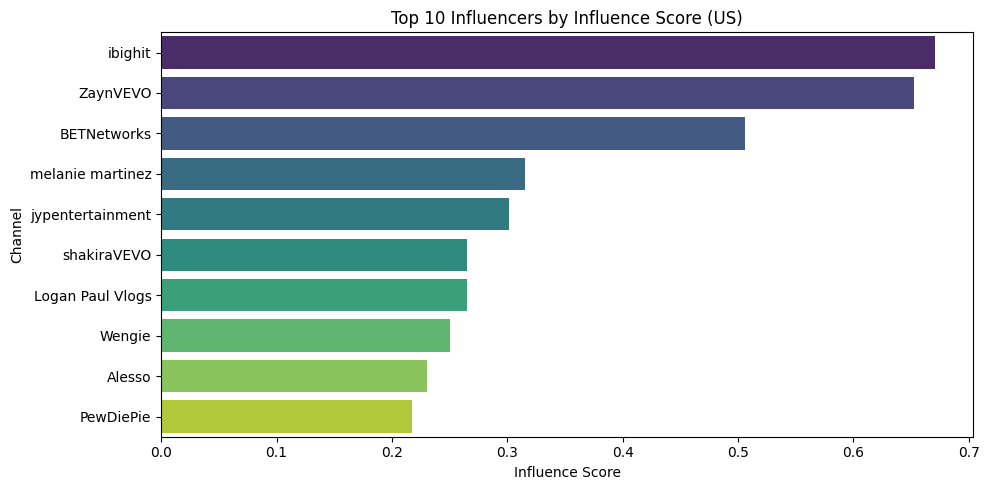

<ipython-input-35-e3e3d9671ea7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_df, x='influence_score', y='channel_title', palette='viridis')


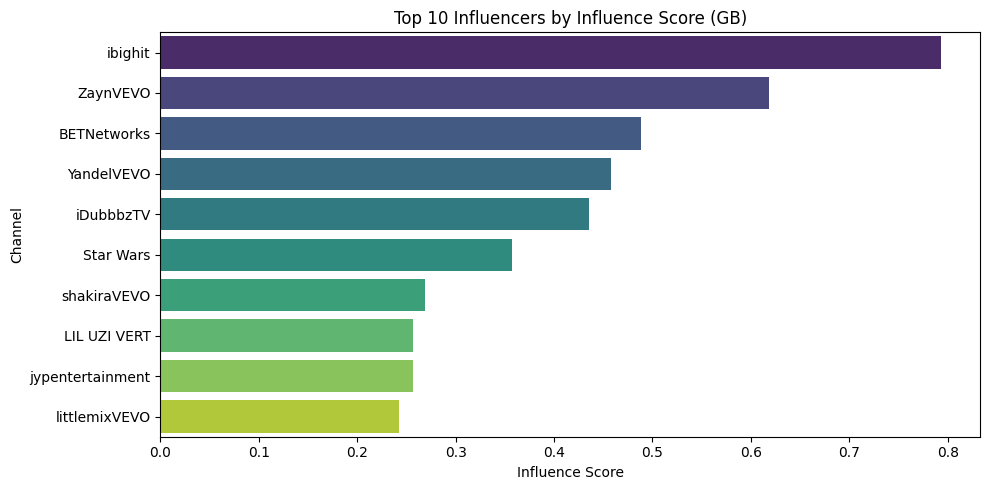

In [ ]:
import matplotlib.pyplot as plt

def plot_top_influencers(df, country='US', top_n=10):
    top_df = df.sort_values(by='influence_score', ascending=False).head(top_n)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_df, x='influence_score', y='channel_title', palette='viridis')
    plt.title(f'Top {top_n} Influencers by Influence Score ({country})')
    plt.xlabel('Influence Score')
    plt.ylabel('Channel')
    plt.tight_layout()
    plt.show()

plot_top_influencers(us_scores, country='US')
plot_top_influencers(gb_scores, country='GB')


### 6. Performance Score

#### 6.1 US Performance Score (Optional)

In [ ]:
# ✅ US: Performance Score
channel_sentiment_us = (
    merged_us.groupby('channel_title')['sentiment']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .reset_index()
)

channel_sentiment_us['sentiment_score'] = (
    (channel_sentiment_us['positive'] - channel_sentiment_us['negative']) /
    (channel_sentiment_us['positive'] + channel_sentiment_us['negative'] + channel_sentiment_us['neutral'] + 1e-9)
)

performance_us = us_scores.merge(
    channel_sentiment_us[['channel_title', 'sentiment_score']],
    on='channel_title',
    how='left'
)
performance_us['sentiment_score'] = performance_us['sentiment_score'].fillna(0)

min_s_us = performance_us['sentiment_score'].min()
max_s_us = performance_us['sentiment_score'].max()
performance_us['norm_sentiment_score'] = (performance_us['sentiment_score'] - min_s_us) / (max_s_us - min_s_us + 1e-9)

performance_us['performance_score'] = (
    0.6 * performance_us['influence_score'] + 0.4 * performance_us['norm_sentiment_score']
)
performance_us['country'] = 'US'


In [ ]:
print("🇺🇸 Top 10 US Influencers by Performance Score:")
print(performance_us.sort_values(by='performance_score', ascending=False)
      [['channel_title', 'influence_score', 'sentiment_score', 'performance_score']].head(10))

🇺🇸 Top 10 US Influencers by Performance Score:
         channel_title  influence_score  sentiment_score  performance_score
0              ibighit         0.670288         0.394444           0.681062
1             ZaynVEVO         0.652278         0.410000           0.673367
2          BETNetworks         0.506081        -0.015000           0.500649
4     jypentertainment         0.301568         0.414716           0.463884
3     melanie martinez         0.315072         0.330000           0.455043
7               Wengie         0.250438         0.382000           0.426663
16          Ed Sheeran         0.147817         0.601667           0.409023
17       Conor Maynard         0.134175         0.640000           0.408505
5          shakiraVEVO         0.265473         0.227143           0.404712
1005  The Royal Butler         0.000509         1.000000           0.400305


#### 6.2 GB Performance Score

In [ ]:
# ✅ GB: Performance Score
channel_sentiment_gb = (
    merged_GB.groupby('channel_title')['bert_sentiment']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .reset_index()
)

channel_sentiment_gb['sentiment_score'] = (
    (channel_sentiment_gb['positive'] - channel_sentiment_gb['negative']) /
    (channel_sentiment_gb['positive'] + channel_sentiment_gb['negative'] + channel_sentiment_gb['neutral'] + 1e-9)
)

performance_gb = gb_scores.merge(
    channel_sentiment_gb[['channel_title', 'sentiment_score']],
    on='channel_title',
    how='left'
)
performance_gb['sentiment_score'] = performance_gb['sentiment_score'].fillna(0)

min_s_gb = performance_gb['sentiment_score'].min()
max_s_gb = performance_gb['sentiment_score'].max()
performance_gb['norm_sentiment_score'] = (performance_gb['sentiment_score'] - min_s_gb) / (max_s_gb - min_s_gb + 1e-9)

performance_gb['performance_score'] = (
    0.6 * performance_gb['influence_score'] + 0.4 * performance_gb['norm_sentiment_score']
)
performance_gb['country'] = 'GB'


In [ ]:
print("\n🇬🇧 Top 10 GB Influencers by Performance Score:")
print(performance_gb.sort_values(by='performance_score', ascending=False)
      [['channel_title', 'influence_score', 'sentiment_score', 'performance_score']].head(10))


🇬🇧 Top 10 GB Influencers by Performance Score:
        channel_title  influence_score  sentiment_score  performance_score
0             ibighit         0.793191         0.498630           0.782396
1            ZaynVEVO         0.617950         0.000000           0.541446
17     booksandquills         0.198206         0.842000           0.518924
2         BETNetworks         0.488180         0.000000           0.463584
3          YandelVEVO         0.457776         0.000000           0.445342
4           iDubbbzTV         0.435147         0.000000           0.431765
8    jypentertainment         0.256254         0.376363           0.426934
281        bubzbeauty         0.058387         0.755000           0.411337
176     sophdoesnails         0.075484         0.669065           0.398191
172     thebrainscoop         0.076748         0.655983           0.395386


<ipython-input-39-f57d10abe0d4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


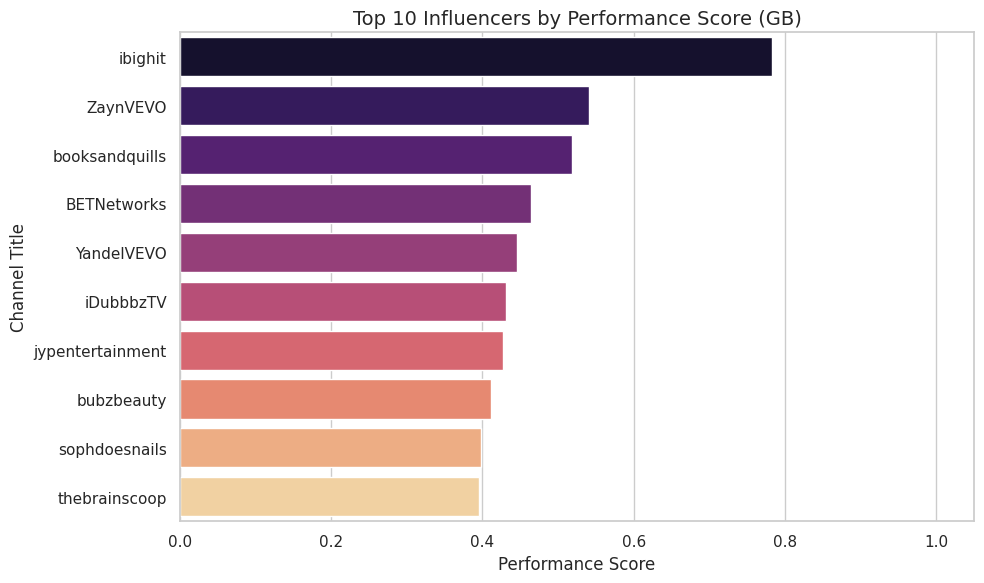

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

def plot_top_performers(df, country_label='US', top_n=10):
    top_df = df.sort_values(by='performance_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_df,
        x='performance_score',
        y='channel_title',
        palette='magma'
    )

    plt.title(f'Top {top_n} Influencers by Performance Score ({country_label})', fontsize=14)
    plt.xlabel('Performance Score')
    plt.ylabel('Channel Title')
    plt.xlim(0, 1.05)
    plt.tight_layout()
    plt.show()

plot_top_performers(performance_gb, country_label='GB')


In [ ]:
# 1️⃣ Rank the top 10 byperformance_score
top10_mixed = performance_gb.sort_values(by='performance_score', ascending=False).head(10)

# 2️⃣ Rank the top channels with highest influence / sentiment / performance scores
top_influence = performance_gb.sort_values(by='influence_score', ascending=False).iloc[0]
top_sentiment = performance_gb.sort_values(by='sentiment_score', ascending=False).iloc[0]
top_performance = performance_gb.sort_values(by='performance_score', ascending=False).iloc[0]

# 3️⃣ Print the results
print("🎯 Top 10 Influencers by Performance Score:")
print(top10_mixed[['channel_title', 'influence_score', 'sentiment_score', 'performance_score']])

print("\n🏆 Highest Influence Score:")
print(top_influence[['channel_title', 'influence_score']])

print("\n💬 Highest Sentiment Score:")
print(top_sentiment[['channel_title', 'sentiment_score']])

print("\n🌟 Highest Performance Score:")
print(top_performance[['channel_title', 'performance_score']])


🎯 Top 10 Influencers by Performance Score:
        channel_title  influence_score  sentiment_score  performance_score
0             ibighit         0.793191         0.498630           0.782396
1            ZaynVEVO         0.617950         0.000000           0.541446
17     booksandquills         0.198206         0.842000           0.518924
2         BETNetworks         0.488180         0.000000           0.463584
3          YandelVEVO         0.457776         0.000000           0.445342
4           iDubbbzTV         0.435147         0.000000           0.431765
8    jypentertainment         0.256254         0.376363           0.426934
281        bubzbeauty         0.058387         0.755000           0.411337
176     sophdoesnails         0.075484         0.669065           0.398191
172     thebrainscoop         0.076748         0.655983           0.395386

🏆 Highest Influence Score:
channel_title       ibighit
influence_score    0.793191
Name: 0, dtype: object

💬 Highest Sentiment Scor

<ipython-input-42-a22a8a7b3e3f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-42-a22a8a7b3e3f>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-42-a22a8a7b3e3f>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


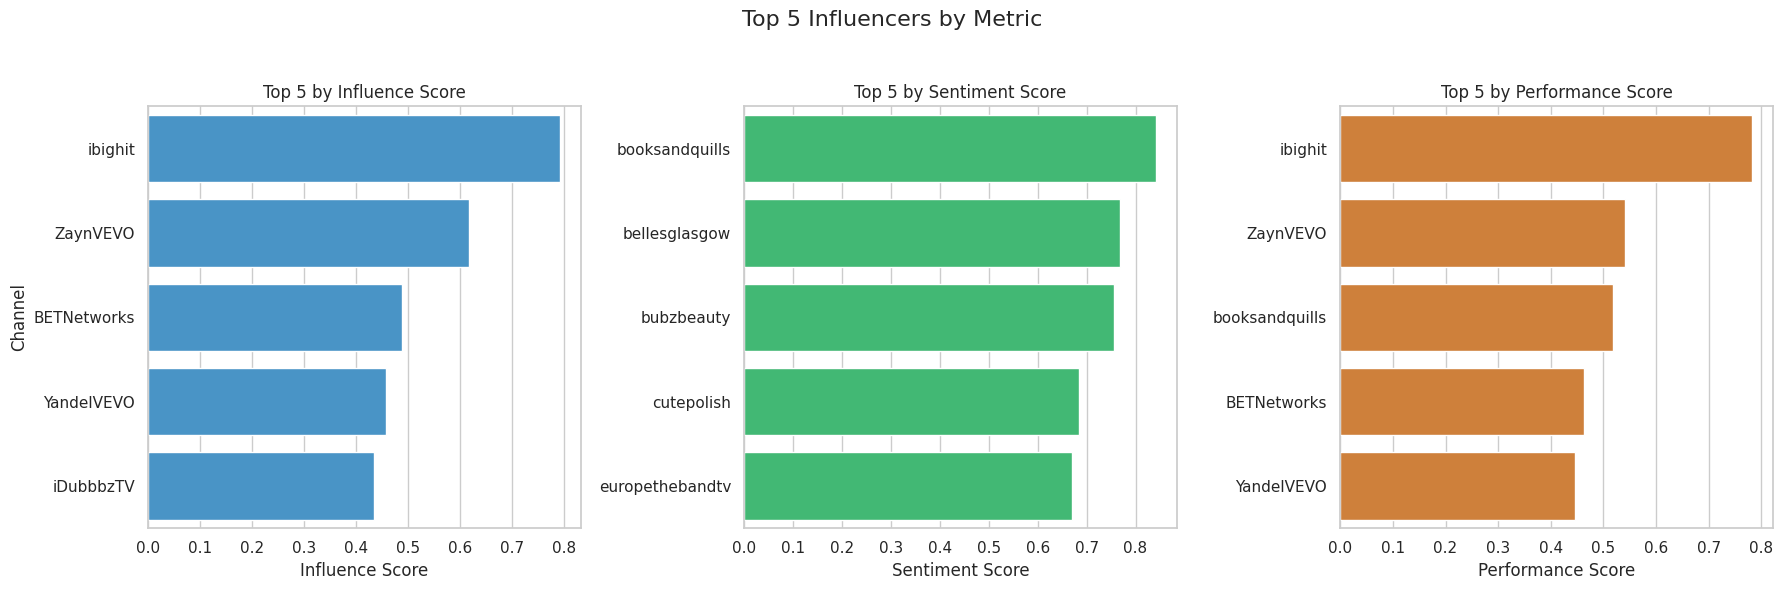

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

top5_influence = performance_gb.sort_values(by='influence_score', ascending=False).head(5)
top5_sentiment = performance_gb.sort_values(by='sentiment_score', ascending=False).head(5)
top5_performance = performance_gb.sort_values(by='performance_score', ascending=False).head(5)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

color_influence = ['#3498db'] * 5
color_sentiment = ['#2ecc71'] * 5
color_performance = ['#e67e22'] * 5

sns.barplot(
    data=top5_influence,
    x='influence_score',
    y='channel_title',
    ax=axes[0],
    palette=color_influence
)
axes[0].set_title("Top 5 by Influence Score")
axes[0].set_xlabel("Influence Score")
axes[0].set_ylabel("Channel")

sns.barplot(
    data=top5_sentiment,
    x='sentiment_score',
    y='channel_title',
    ax=axes[1],
    palette=color_sentiment
)
axes[1].set_title("Top 5 by Sentiment Score")
axes[1].set_xlabel("Sentiment Score")
axes[1].set_ylabel("")

sns.barplot(
    data=top5_performance,
    x='performance_score',
    y='channel_title',
    ax=axes[2],
    palette=color_performance
)
axes[2].set_title("Top 5 by Performance Score")
axes[2].set_xlabel("Performance Score")
axes[2].set_ylabel("")

plt.suptitle("Top 5 Influencers by Metric", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### 7. LLM Integration

Use case: The stakeholder has received a ranked list of top-performing YouTube influencers. They now want a quick, high-level understanding of what the audience typically says about each influencer in the comment sections, to complement the quantitative scores with qualitative audience insights.




In [ ]:
import requests
import pandas as pd

def summarize_channel_comments(channel_title, dataframe, api_key, n_comments=200, model="gpt-4o"):
    """
    Summarizes YouTube comment sentiment and themes for a given channel using OpenAI GPT API.

    Parameters:
    - channel_title (str): The name of the YouTube channel.
    - dataframe (pd.DataFrame): DataFrame with 'channel_title' and 'comment_text' columns.
    - api_key (str): Your OpenAI API key.
    - n_comments (int): Number of comments to sample (default = 200).
    - model (str): OpenAI model name (default = "gpt-4o").

    Returns:
    - str: A summary of audience sentiment and comment themes.
    """

    # Filter comments for the channel
    filtered = dataframe[dataframe['channel_title'].str.lower() == channel_title.lower()]
    comments = filtered['comment_text'].dropna()

    if comments.empty:
        return f"No comments found for channel '{channel_title}'."

    sample = comments.sample(n=min(n_comments, len(comments)))
    comments_block = "\n".join(sample.tolist())

    # Build prompt
    user_prompt = f"""
    You are given a collection of YouTube comments for the channel '{channel_title}'.
    Summarize the audience sentiment and recurring themes or topics in the comments.
    Highlight both positive and negative reactions if any.

    Here are the comments:
    {comments_block}
    """

    # Call GPT
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": "You are an assistant helping summarize social media feedback."},
            {"role": "user", "content": user_prompt}
        ],
        "temperature": 0.7
    }

    response = requests.post(url, headers=headers, json=payload)

    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        return f"Error {response.status_code}: {response.text}"


Test with 'ibighit' from merged_us

In [ ]:
# Replace with your API key
api_key = ""

# Call the function for a specific channel
summary = summarize_channel_comments("ibighit", merged_GB, api_key)
print(summary)

The comments for the 'ibighit' channel predominantly reflect a very positive and enthusiastic sentiment from the audience, with several recurring themes and topics. Most comments express excitement and admiration for BTS, specifically focusing on their new release and the members, especially Jungkook. Fans are thrilled about the music video, eagerly anticipating more content, and express their love and support through numerous heart and smiley emojis.

Key positive reactions include:
- Excitement for the release, with many users expressing love for the music and its catchy nature.
- Great anticipation for live performances and more teasers.
- Strong support for BTS, with many comments urging others to stream the video and vote for the group in various competitions.
- Admiration for the appearance and talent of the band members, particularly Jungkook and Jimin.

On the other hand, a few negative elements were noted:
- Displeasure towards the number of dislikes on the video, with a speci

Test with 'booksandquills' from merged_GB

In [ ]:
# Replace with your API key
api_key = ""

# Call the function for a specific channel
summary = summarize_channel_comments("booksandquills", merged_GB, api_key)
print(summary)

The audience sentiment for the 'booksandquills' channel is overwhelmingly positive. The comments reveal a deep appreciation for the video content, with viewers frequently expressing their admiration using words like "beautiful," "amazing," "wonderful," and "stunningly done." Many commenters mention feeling emotionally moved, with phrases like "This made me emotional," "I feel like I could cry," and "I'm very moved." The recurring themes include a love and appreciation for books, the beauty of the video’s production, and the emotional resonance it evokes in viewers.

Positive reactions are dominant, with viewers praising the creativity and aesthetic quality of the video, often referring to it as "beautifully made" and "touching." The doodles in the video are specifically highlighted as a delightful aspect by several commenters. There are also mentions of personal connections to the topic, such as the challenge of keeping up with reading and the emotional impact of realizing the limited 

### 8.Industry-Specific Analysis

Targeted Industry/Sample Business Case: Cosmetics Company <br>
We will leverage LLM to recommend suitable categories to choose youtubers to collorate with



In [ ]:
import requests

def get_cosmetics_category_recommendation(api_key):
    url = "https://api.openai.com/v1/chat/completions"

    prompt = """
I am a brand manager at a cosmetics company planning a YouTube influencer marketing campaign. I have access to a list of YouTube video categories and want to identify which categories are most suitable for collaborating with influencers to promote cosmetics products.

Please select the most relevant categories based on audience fit, content style, and influencer alignment, and explain your reasoning. Here is the category list:

{
    1: 'Film & Animation',
    2: 'Autos & Vehicles',
    10: 'Music',
    15: 'Pets & Animals',
    17: 'Sports',
    19: 'Travel & Events',
    20: 'Gaming',
    22: 'People & Blogs',
    23: 'Comedy',
    24: 'Entertainment',
    25: 'News & Politics',
    26: 'Howto & Style',
    27: 'Education',
    28: 'Science & Technology',
    29: 'Nonprofits & Activism',
    43: 'Shows'
}
"""

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "gpt-4o",
        "messages": [
            {"role": "system", "content": "You are a marketing assistant that provides clear, business-oriented recommendations."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.7
    }

    response = requests.post(url, headers=headers, json=payload)

    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        return f"❌ Error {response.status_code}: {response.text}"


In [ ]:
# Replace with your API key
api_key = ""
print(get_cosmetics_category_recommendation(api_key))


For a cosmetics company aiming to launch a YouTube influencer marketing campaign, selecting the most suitable categories is crucial to reaching a relevant audience and ensuring effective promotion. Here are the top categories to consider:

1. **Howto & Style (Category 26)**:
   - **Audience Fit**: This category is highly relevant as it attracts viewers interested in personal grooming, fashion, beauty tutorials, and styling tips.
   - **Content Style**: Influencers in this category often create content focused on makeup tutorials, beauty routines, product reviews, and style advice, making it an ideal platform for cosmetics products.
   - **Influencer Alignment**: Many beauty influencers operate within this category, providing a direct channel to potential customers interested in cosmetics.

2. **People & Blogs (Category 22)**:
   - **Audience Fit**: This category often includes lifestyle content that can encompass beauty and personal care topics.
   - **Content Style**: Influencers here

In [ ]:
# Step 1: Define cosmetics categories and weights
cosmetics_categories = [26, 22, 24, 10]
manual_weights = pd.DataFrame({
    'category_id': [26, 22, 24, 10],
    'category_weight': [0.4, 0.3, 0.2, 0.1]
})

# Step 2: Filter performance_gb to cosmetics-related content
cosmetics_df = merged_GB[merged_GB['category_id'].isin(cosmetics_categories)]

# Step 3: Compute avg performance_score per influencer per category (not deduplicated!)
channel_category_perf = (
    cosmetics_df[['channel_title', 'category_id']]
    .merge(performance_gb[['channel_title', 'performance_score']], on='channel_title')
    .groupby(['channel_title', 'category_id'], as_index=False)
    .agg({'performance_score': 'mean'})  # or sum if you prefer
)

# Step 4: Merge with manual weights
channel_category_perf = channel_category_perf.merge(manual_weights, on='category_id', how='left')
channel_category_perf['weighted_score'] = channel_category_perf['performance_score'] * channel_category_perf['category_weight']

# Step 5: Aggregate to final score per influencer
final_scores = (
    channel_category_perf
    .groupby('channel_title', as_index=False)['weighted_score']
    .sum()
    .rename(columns={'weighted_score': 'final_score'})
)

# Step 6: Merge for full table (including breakdown)
full_table = channel_category_perf.merge(final_scores, on='channel_title', how='left')
full_table = full_table.sort_values(by='final_score', ascending=False)

full_table

,channel_title,category_id,performance_score,category_weight,weighted_score,final_score
540,bubzbeauty,26,0.411337,0.4,0.164535,0.164535
587,sophdoesnails,26,0.398191,0.4,0.159276,0.159276
539,booksandquills,22,0.518924,0.3,0.155677,0.155677
568,kawaiisweetworld,26,0.383488,0.4,0.153395,0.153395
538,blogilates,26,0.382918,0.4,0.153167,0.153167
...,...,...,...,...,...,...
597,y2ksale,24,0.081064,0.2,0.016213,0.016213
589,stuhutchings,10,0.147154,0.1,0.014715,0.014715
591,tlc uk,24,0.061372,0.2,0.012274,0.012274
548,djvlad,24,0.049058,0.2,0.009812,0.009812


<ipython-input-70-e418e3f06d89>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top3, x='final_score', y='channel_title', palette='magma')


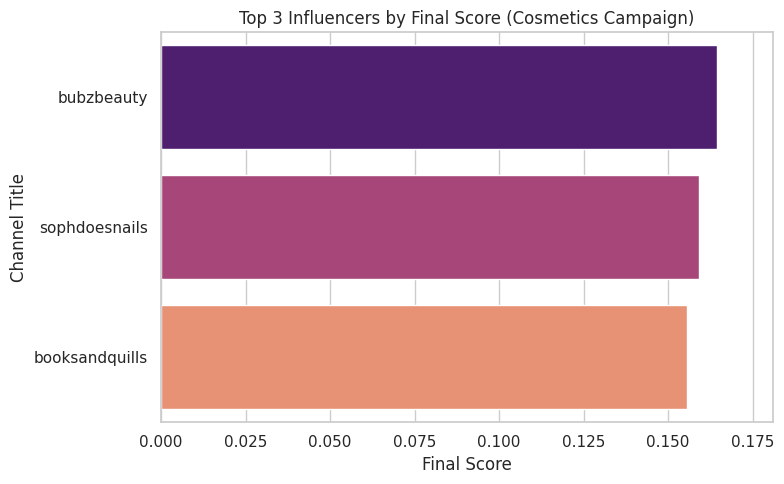

In [ ]:
# Top 3 chart
top3 = full_table[['channel_title', 'final_score']].drop_duplicates().head(3)
plt.figure(figsize=(8, 5))
sns.barplot(data=top3, x='final_score', y='channel_title', palette='magma')
plt.title('Top 3 Influencers by Final Score (Cosmetics Campaign)')
plt.xlabel('Final Score')
plt.ylabel('Channel Title')
plt.xlim(0, top3['final_score'].max() * 1.1)
plt.tight_layout()
plt.show()

In [ ]:
# danisnotinteresting
full_table[full_table['channel_title'] == 'danisnotinteresting']

,channel_title,category_id,performance_score,category_weight,weighted_score,final_score
543,danisnotinteresting,22,0.250069,0.3,0.075021,0.125035
544,danisnotinteresting,24,0.250069,0.2,0.050014,0.125035
